# **Lab 6 Transfer Learning & Hyperparameter Tuning**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
import cv2
from skimage.util import random_noise
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

seed = 4912
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

## Data Preparation
Complete the class `CustomImageDataset()` that `__getitem__` return ***noisy blury*** image and ***ground truth*** image.
Please ensure that the final image is in RGBscale and has a size of 128x128.

In [6]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, image_paths,gauss_noise=False,gauss_blur=None,resize=128,p=0.5, center_crop=False, transform=None):
        self.p = p
        self.resize = resize
        self.gauss_noise = gauss_noise
        self.gauss_blur = gauss_blur
        self.center_crop = center_crop
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def add_gaussian_noise(self, image):
        #สร้าง gaussian noise
        x, y, channel = image.shape
        mean = random.uniform(-50, 50)
        gaussian_noise = np.random.normal(loc=mean,scale=100,size=(x,y,channel)).astype(np.float32)
        #ภาพ ผสมกับ Gaussian Noise
        noisy_image = image + gaussian_noise
        return np.clip(noisy_image, 0, 255).astype(np.uint8)

    def do_gaussian_blur(self, image):
        kernel_size = random.randrange(3, 12, 2)
        return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0) #ภาพ,Kernel Size, Standard Deviation
    
    def do_center_crop(self, image, desire_h=128, desire_w=128):
        height,width, _ = image.shape
        if width <= height: #กรณี width สั้น ให้ resize โดยยึด width 
            #ปรับ width เทียบเท่าแล้ว เหลือ Height ที่ยังเกิน
            #เพื่อให้สัดส่วนคงเดิม ไม่ถูกบีบ ให้หาอัตราส่วนภาพ
            img_ratio = height / width
            image = cv2.resize(image, (self.resize, int(self.resize*img_ratio))) #image , (width, height) ที่จะไป
            #พอ resize แล้ว จะได้ width height ตัวใหม่ 
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[new_resize_h//2 - self.resize//2: new_resize_h//2 + self.resize//2, 0:self.resize]
        else:
            #ปรับ Height เทียบเท่าแล้ว เหลือ width ที่ยังเกิน
            img_ratio = width / height
            image = cv2.resize(image, (int(self.resize*img_ratio), self.resize))
            new_resize_h, new_resize_w, _ = image.shape
            crop_img = image[0:self.resize, new_resize_w//2 - self.resize//2: new_resize_w//2 + self.resize//2]
        return crop_img

    def __getitem__(self, idx):
        image_paths = self.image_paths[idx]
        img = plt.imread(image_paths)
        if img.ndim == 2: #ถ้าเป็น Gray --> บังคับเป็น RGB Format
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        
        #ถ้าทำ center crop ก็ไม่ต้องทำ Resize, เลือกอย่างใดอย่างนึง
        if(self.center_crop):
            gt_image = self.do_center_crop(img, desire_h=self.resize, desire_w=self.resize)
            # print("*******")
            # print(gt_image.shape)
        else:
            gt_image = cv2.resize(img, (self.resize, self.resize))  #Ground truth image
        image = gt_image.copy()

    # Ensure minimum size of 7x7
        if image.shape[0] < 7 or image.shape[1] < 7:
            image = cv2.resize(image, (max(7, image.shape[1]), max(7, image.shape[0])))
        if gt_image.shape[0] < 7 or gt_image.shape[1] < 7:
            gt_image = cv2.resize(gt_image, (max(7, gt_image.shape[1]), max(7, gt_image.shape[0])))
            
            
        #ใส่ความน่าจะเป็น ที่จะถูก Apply G-noise, G-blur
        if self.p >= 0.5:
            if self.gauss_noise:
                image = self.add_gaussian_noise(image)
            if self.gauss_blur:
                image = self.do_gaussian_blur(image)
        # print("===================")
        # print(f"Image shape: {image.shape}")
        if self.transform:
            image = self.transform(image)
            gt_image = self.transform(gt_image)
        return image, gt_image
### END CODE HERE ###

In [7]:
### START CODE HERE ###
def imshow_grid(images):
    fig = plt.figure(figsize=(10, 5))
    #หาว่า จะใช้เท่าไหร่ดี อิงจากจำนวนรูปภาพ
    num_images = len(images)
    # print(num_images)
    #ตัดที่ 4 รูป
    grid_size = int(np.ceil(np.sqrt(num_images)))
    # print(grid_size)
    for i in range(num_images):
        a = fig.add_subplot(grid_size, grid_size, i + 1)
        plt.imshow(images[i])
        a.axis("off")
    plt.tight_layout()
    plt.show()
### END CODE HERE ###

In [9]:
### START CODE HERE ###
data_dir = "data/img_align_celeba"
image_paths = []
for file_name in os.listdir(data_dir):
    image_paths.append(f"{data_dir}/{file_name}")
print(image_paths)
dataset = CustomImageDataset(image_paths=image_paths,
                             gauss_noise=True,
                             gauss_blur=True,
                             resize=128,
                             p=0.5,
                             center_crop=True
                            )
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)
### END CODE HERE ###

['data/img_align_celeba/000001.jpg', 'data/img_align_celeba/000002.jpg', 'data/img_align_celeba/000003.jpg', 'data/img_align_celeba/000004.jpg', 'data/img_align_celeba/000005.jpg', 'data/img_align_celeba/000006.jpg', 'data/img_align_celeba/000007.jpg', 'data/img_align_celeba/000008.jpg', 'data/img_align_celeba/000009.jpg', 'data/img_align_celeba/000010.jpg', 'data/img_align_celeba/000011.jpg', 'data/img_align_celeba/000012.jpg', 'data/img_align_celeba/000013.jpg', 'data/img_align_celeba/000014.jpg', 'data/img_align_celeba/000015.jpg', 'data/img_align_celeba/000016.jpg', 'data/img_align_celeba/000017.jpg', 'data/img_align_celeba/000018.jpg', 'data/img_align_celeba/000019.jpg', 'data/img_align_celeba/000020.jpg', 'data/img_align_celeba/000021.jpg', 'data/img_align_celeba/000022.jpg', 'data/img_align_celeba/000023.jpg', 'data/img_align_celeba/000024.jpg', 'data/img_align_celeba/000025.jpg', 'data/img_align_celeba/000026.jpg', 'data/img_align_celeba/000027.jpg', 'data/img_align_celeba/0000

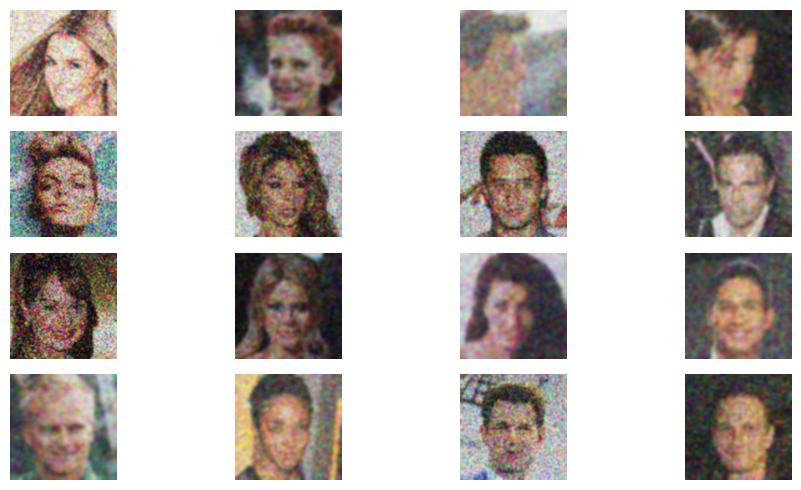

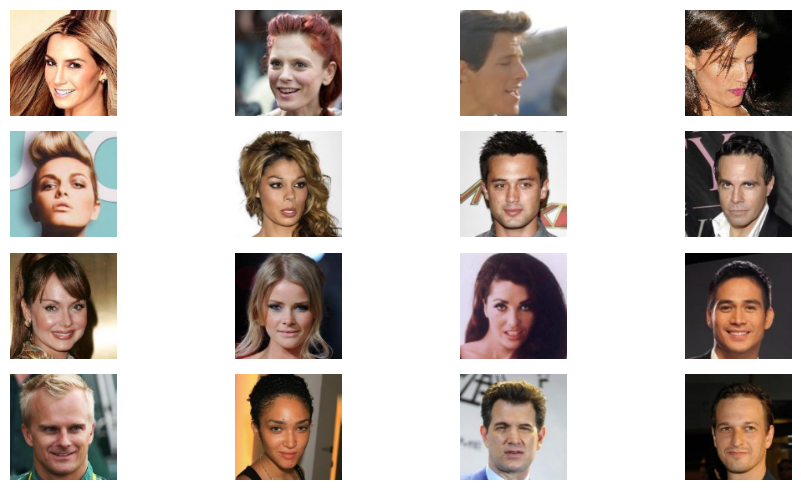

In [10]:
### START CODE HERE ###
batch,gt_img = next(iter(dataloader)) 
imshow_grid(batch)
imshow_grid(gt_img)
### END CODE HERE ###

## Create Autoencoder model
You can design your own Autoencoder model with a customizable number of downsampling and upsampling blocks by passing a list of channel numbers for each layer based on the provided code below. However, please maintain the concept of 'Autoencoder'.

In [11]:
### START CODE HERE ###
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        #Encoder
        self.conv_in = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.down1 = DownSamplingBlock(64, 128, kernel_size=3, stride=1, padding=1)
        ### DESIGN YOUR OWN MODEL ###
        self.down2 = DownSamplingBlock(128, 256, kernel_size=3, stride=1, padding=1)
        #Decoder
        self.up3 = UpSamplingBlock(256, 128, kernel_size=3, stride=1, padding=1)
        self.up4 = UpSamplingBlock(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        if x.dim() == 4 and x.size(1) != 3:
            # สลับจาก [batch_size, height, width, channels] to [batch_size, channels, height, width]
            x = x.permute(0, 3, 1, 2)
        x = self.conv_in(x)
        x = self.down1(x)
        x = self.down2(x)
        
        x = self.up3(x)
        x = self.up4(x)
        x = self.conv(x)
        return x

### END CODE HERE ###
        

## Train Autoencoder
Complete the `train()` function in the cell below. This function should evaluate the model at every epoch, log the ***training loss, test loss,test PSNR, test SSIM***. Additionally, it should save the model at the last epoch.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The log should resemble this, but not be identical

```
🤖Training on cuda
🚀Training Epoch [1/1]: 100%|██████████| 1313/1313 [01:45<00:00, 12.41batch/s, loss=0.0102] 
📄Testing: 100%|██████████| 563/563 [01:10<00:00,  7.95batch/s, loss=0.0106, psnr=16.7, ssim=0.348] 
Summary :
	Train	avg_loss: 0.017262999383663165
	Test	avg_loss: 0.010476540363861867 
                PSNR : 16.839487147468034 
                SSIM : 0.36090552368883694
...
```

</details>

Resource : [PyTorch Training loop](<https://pytorch.org/tutorials/beginner/introyt/trainingyt.html#:~:text=%3D0.9)-,The%20Training%20Loop,-Below%2C%20we%20have>), [PSNR & SSIM](https://ieeexplore.ieee.org/document/5596999)

In [12]:
### START CODE HERE ###
def train(model, opt, loss_fn, train_loader, test_loader, epochs=10, checkpoint_path=None, device='cpu'):
    print("🤖 Training on", device)
    model = model.to(device)

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, gt in train_bar:
            images, gt = images.float().to(device), gt.float().to(device)

            # Forward pass
            outputs = model(images)
            
            # ปรับตำแหน่ง ให้เข้า pytorch ได้
            if outputs.shape != gt.shape:
                gt = gt.permute(0, 3, 1, 2)  # เรียงแบบ [batch_size, channels, height, width]
            
            loss = loss_fn(outputs, gt)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            running_train_loss += loss.item()
            train_bar.set_postfix(loss=loss.item())

        avg_train_loss = running_train_loss / len(train_loader)

        # Evaluation phase (ประเมิณ เพื่อปรับปรุง)
        model.eval()
        running_test_loss = 0.0
        running_psnr = 0.0
        running_ssim = 0.0
        with torch.no_grad():
            test_bar = tqdm(test_loader, desc='📄 Testing', unit='batch')
            for images, gt in test_bar:
                images, gt = images.float().to(device), gt.float().to(device)
                
                # Forward pass
                outputs = model(images)

                # Check and adjust shape to match
                if outputs.shape != gt.shape:
                    gt = gt.permute(0, 3, 1, 2)
                
                loss = loss_fn(outputs, gt)

                # Convert tensors to numpy arrays and use permute to reorder dimensions
                outputs_np = outputs.cpu().permute(0, 2, 3, 1).numpy()
                gt_np = gt.cpu().permute(0, 2, 3, 1).numpy()
                
                # Calculate PSNR and SSIM with data range set explicitly
                data_range = gt_np.max() - gt_np.min()
                batch_psnr = np.mean([psnr(gt_np[i], outputs_np[i], data_range=data_range) for i in range(outputs_np.shape[0])])
                
                # Calculate SSIM
                batch_ssim = []
                for i in range(outputs_np.shape[0]):
                    min_dim = min(gt_np[i].shape[0], gt_np[i].shape[1])
                    if min_dim >= 7:
                        win_size = min(7, min_dim)
                        if win_size % 2 == 0:
                            win_size -= 1  # Ensure odd window size
                        ssim_value = ssim(gt_np[i], outputs_np[i], win_size=win_size, data_range=data_range, channel_axis=-1)
                    else:
                        # For images smaller than 7x7, use MSE instead of SSIM
                        ssim_value = -np.mean((gt_np[i] - outputs_np[i])**2)  # Negative MSE as a proxy for SSIM
                    batch_ssim.append(ssim_value)
                batch_ssim = np.mean(batch_ssim)

                running_test_loss += loss.item()
                running_psnr += batch_psnr
                running_ssim += batch_ssim

                test_bar.set_postfix(loss=loss.item(), psnr=batch_psnr, ssim=batch_ssim)

        avg_test_loss = running_test_loss / len(test_loader)
        avg_psnr = running_psnr / len(test_loader)
        avg_ssim = running_ssim / len(test_loader)

        print(f'Summary :\n\tTrain\tavg_loss: {avg_train_loss:.4f}\n\tTest\tavg_loss: {avg_test_loss:.4f} \n\t\tPSNR : {avg_psnr:.4f} \n\t\tSSIM : {avg_ssim:.4f}')

        # Save model at the end of each epoch
        if checkpoint_path:
            torch.save(model.state_dict(), f'{checkpoint_path}_epoch_{epoch+1}.pth')
            print(f'Model saved to {checkpoint_path}_epoch_{epoch+1}.pth')
### END CODE HERE ###

Let's train your model with 2 epochs to verify that your train() function works properly. After that, we'll move on to the Hyperparameter Grid Search in the next part.

In [13]:
### START CODE HERE ###
data_dir = "data/img_align_celeba"

# files = os.listdir(data_dir)
# files = [os.path.normpath(os.path.join(data_dir, file)) for file in files]
# print(files)
files = []
for file_name in os.listdir(data_dir):
    files.append(f"{data_dir}/{file_name}")
print(files[0])

# Split ข้อมูล
train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)


train_dataset = CustomImageDataset(train_files)
test_dataset = CustomImageDataset(test_files)
trainloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)
### END CODE HERE ###

data/img_align_celeba/000001.jpg


In [32]:
### START CODE HERE ###

model = Autoencoder()
opt = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
train(model, opt, loss_fn, trainloader, testloader, epochs=2, checkpoint_path='autoencoder.pth', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

🤖 Training on cuda


📄 Testing: 100%|██████████| 188/188 [00:49<00:00,  3.79batch/s, loss=348, psnr=23.6, ssim=0.724]


Summary :
	Train	avg_loss: 764.6951
	Test	avg_loss: 298.7332 
		PSNR : 23.8233 
		SSIM : 0.7497
Model saved to autoencoder.pth_epoch_1.pth


📄 Testing: 100%|██████████| 188/188 [00:24<00:00,  7.79batch/s, loss=338, psnr=23.5, ssim=0.754]

Summary :
	Train	avg_loss: 303.9127
	Test	avg_loss: 341.3141 
		PSNR : 23.1942 
		SSIM : 0.7763
Model saved to autoencoder.pth_epoch_2.pth


---

## **Hyperparameter Grid Search with Raytune**

*If you have access to APEX, I would recommend converting this part into a Python file and submitting the job to run on APEX using SBATCH. This process may take a considerable amount of time.*

You can import additional Ray Tune tools as you want, such as schedulers, search algorithms, etc. Further information on the usage of Ray Tune can be found [here](https://docs.ray.io/en/latest/tune/index.html).

In [14]:
import ray
from ray import tune
from ray.air import session


ray.shutdown()

Complete the `train_raytune()` function below, following the [quick start guide](https://docs.ray.io/en/latest/tune/index.html). This function will be passed to the `tune.Tuner`.

In [15]:
### START CODE HERE ###
def train_raytune(config):

    print(f"Starting trial with config: {config}")
    print(f"Number of training samples: {len(train_dataset)}")
    print(f"Number of testing samples: {len(test_dataset)}")
    try:
        trainloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
        testloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)
        
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model = Autoencoder()
        model = model.to(device)
        loss_fn = nn.MSELoss()
        
        if config['optimizer'] == 'Adam':
            opt = torch.optim.Adam(model.parameters(), lr=config['lr'])
        elif config['optimizer'] == 'SGD':
            opt = torch.optim.SGD(model.parameters(), lr=config['lr'])
        
        for epoch in range(config['num_epochs']):
            model.train()
            avg_train_loss = 0
            for images, _ in trainloader:
                images = images.to(device)
                output = model(images)
                loss = loss_fn(output, images)
                
                opt.zero_grad()
                loss.backward()
                opt.step()
                
                avg_train_loss += loss.item()
            
            avg_train_loss /= len(trainloader)
            
            total_psnr = 0
            total_ssim = 0
            model.eval()
            with torch.no_grad():
                for images, _ in testloader:
                    images = images.to(device)
                    output = model(images)
                    loss = loss_fn(output, images)
                    
                    output_np = output.cpu().numpy().transpose(0, 2, 3, 1)
                    images_np = images.cpu().numpy().transpose(0, 2, 3, 1)
                    
                    batch_size = output_np.shape[0]
                    for i in range(batch_size):
                        img = images_np[i]
                        rec_img = output_np[i]
                        total_psnr += psnr(img, rec_img, data_range=1.0)
                        total_ssim += ssim(img, rec_img, data_range=1.0, multichannel=True)
                    
                    avg_test_loss += loss.item()
            
            avg_psnr = total_psnr / len(testloader)
            avg_ssim = total_ssim / len(testloader)
            avg_test_loss /= len(testloader)
            
            session.report({
                "train_loss": avg_train_loss,
                "val_loss": avg_test_loss,
                "val_psnr": avg_psnr,
                "val_ssim": avg_ssim,
            })
    except Exception as e:
        print(f"An error occurred during training: {str(e)}")
        raise
        
### END CODE HERE ###

Initialize Ray, define the search space, and resources.

Resource : 
- [A Guide To Parallelism and Resources for Ray Tune](https://docs.ray.io/en/latest/tune/tutorials/tune-resources.html#:~:text=A%20Guide%20To%20Parallelism%20and%20Resources%20for%20Ray%20Tune) 
- [Working with Tune Search Spaces](https://docs.ray.io/en/latest/tune/tutorials/tune-search-spaces.html#tune-search-space-tutorial:~:text=Working%20with%20Tune%20Search%20Spaces)
- [How to configure logging in Tune?](https://docs.ray.io/en/latest/tune/tutorials/tune-output.html) 
- [Tune Trial Schedulers (`tune.schedulers`)](https://docs.ray.io/en/latest/tune/api/schedulers.html#tune-scheduler-pbt:~:text=Tune%20Trial...-,Tune%20Trial%20Schedulers%20(tune.schedulers),-%23)

**Search Space:**
- `architecture`:<br>
    Feature map dimensions for convolutional layers<br>
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with more depth, starting from 64 and ending at 512.
- `learning rates (lr)`:
    - [1e-3, 8e-4, 1e-4, 1e-2]: Test a wide range of learning rates to evaluate model performance, from 1e-3 (typical) to a more aggressive 1e-2 or conservative 1e-4.
- `batch size`:
    - [16, 32]: Explore smaller batch sizes to evaluate their impact on gradient estimation and memory usage.
- `number of epochs`:
    - `[10, 50, 100]`: Allow short and long training sessions, from quick evaluations (10 epochs) to more extensive training (100 epochs).
- `optimizers (opts)`:
    - `["Adam", "SGD"]`: Compare two popular optimization algorithms: Adam for adaptive learning rates and SGD for momentum-based updates.

In [35]:
import ray
from ray import tune
from ray.air import session
# Define the DownSamplingBlock and UpSamplingBlock classes
class DownSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(DownSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        return x

class UpSamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(UpSamplingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.upsample(x)
        return x

class Autoencoder(nn.Module):
    def __init__(self, architecture):
        super().__init__()

        # Ensure that architecture is a list of integers
        if not all(isinstance(x, int) for x in architecture):
            raise ValueError(f"Expected a list of integers for architecture, but got: {architecture}")

        # Encoder
        layers = []
        in_channels = 3
        for out_channels in architecture:
            layers.append(DownSamplingBlock(in_channels, out_channels))
            in_channels = out_channels
        self.encoder = nn.Sequential(*layers)

        # Decoder
        layers = []
        for i, out_channels in enumerate(reversed(architecture)):
            if i == 0:
                layers.append(UpSamplingBlock(in_channels, out_channels))
                in_channels = out_channels
            else:
                layers.append(UpSamplingBlock(in_channels * 2, out_channels))
                in_channels = out_channels
        self.decoder = nn.Sequential(*layers)

        self.conv_out = nn.Conv2d(architecture[-1], 3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = self.conv_out(x)
        return x



def train_raytune(config):
    # Access the architecture directly
    architecture = config['architecture']
    print(f"Architecture config: {architecture}")
    
    # Set up the device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Set up the model based on the sampled architecture
    try:
        model = Autoencoder(architecture).to(device)
        print("Model initialized successfully.")
    except Exception as e:
        print(f"Error initializing model: {e}")
        return
    
    # Select the optimizer
    if config['optimizer'] == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])

    # Loss function (Mean Squared Error for Autoencoder)
    criterion = nn.MSELoss()

    # Set up data augmentation and loaders
    transform = transforms.Compose([transforms.ToTensor()])
    data_dir = "data/img_align_celeba"

    if not os.path.exists(data_dir):
        raise FileNotFoundError(f"Data directory {data_dir} not found.")
    
    files = [os.path.join(data_dir, file_name) for file_name in os.listdir(data_dir)]
    print("Sample file:", files[0])

    # Split data
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    # Initialize datasets with the transformation
    train_dataset = CustomImageDataset(train_files, transform=transform)
    test_dataset = CustomImageDataset(test_files, transform=transform)

    # Define DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=0)
    val_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=0)
    print("Data loaders created.")
    
    # Training loop
    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        for inputs, _ in train_loader:
            inputs = inputs.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Autoencoder output is compared to input
            
            # Backward and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        # Validation and PSNR calculation
        model.eval()
        val_psnr = 0.0
        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                
                # PSNR calculation
                inputs_np = inputs.cpu().numpy()
                outputs_np = outputs.cpu().numpy()
                val_psnr += psnr(inputs_np, outputs_np, data_range=1.0)

        # Average PSNR for validation set
        avg_val_psnr = val_psnr / len(val_loader)

        # Report the PSNR to Ray Tune
        session.report({"val_psnr": avg_val_psnr})

    print(f"Finished training with config: {config}")


ray.shutdown()
ray.init(num_gpus=1, ignore_reinit_error=True)
# # Define the trial directory naming function
# def short_dirname(trial):
#     return "trial_" + str(trial.trial_id)

# # Define the configuration for hyperparameter tuning
config = {
    'architecture': tune.choice([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),
    'lr': tune.choice([1e-3, 8e-4, 1e-4, 1e-2]),
    'batch_size': tune.choice([16, 32]),
    'num_epochs': tune.choice([10, 50, 100]),
    'optimizer': tune.choice(['Adam', 'SGD']),
}
print("HHHHHHHHHHHHHHHH")

train_raytune(config)
# Run the Ray Tune hyperparameter search
try:
    result = tune.run(
        train_raytune,
        config=config,
        num_samples=10,
        trial_dirname_creator=short_dirname,
        metric="val_psnr",
        mode="max",
        verbose=2  # Increase verbosity
    )
    print("Hyperparameter tuning completed successfully.")
    print("Best config:", result.get_best_config(metric="val_psnr", mode="max"))
except Exception as e:
    print(f"An error occurred during hyperparameter tuning: {str(e)}")
    raise

2024-09-15 17:44:22,182	INFO worker.py:1783 -- Started a local Ray instance.
2024-09-15 17:44:24,430	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


HHHHHHHHHHHHHHHH
Architecture config: <ray.tune.search.sample.Categorical object at 0x00000215AD4DBF50>
Error initializing model: Expected a list of integers for architecture, but got: <ray.tune.search.sample.Categorical object at 0x00000215AD4DBF50>


(train_raytune pid=1620) Architecture config: [64, 128, 256]


2024-09-15 17:44:33,446	ERROR tune_controller.py:1331 -- Trial task failed for trial train_raytune_792d9_00003
Traceback (most recent call last):
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                        

(train_raytune pid=1620) Model initialized successfully.


Trial name
train_raytune_792d9_00000
train_raytune_792d9_00001
train_raytune_792d9_00002
train_raytune_792d9_00003
train_raytune_792d9_00004
train_raytune_792d9_00005
train_raytune_792d9_00006
train_raytune_792d9_00007
train_raytune_792d9_00008
train_raytune_792d9_00009


2024-09-15 17:44:33,463	ERROR tune_controller.py:1331 -- Trial task failed for trial train_raytune_792d9_00002
Traceback (most recent call last):
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                        

An error occurred during hyperparameter tuning: ('Trials did not complete', [train_raytune_792d9_00000, train_raytune_792d9_00001, train_raytune_792d9_00002, train_raytune_792d9_00003, train_raytune_792d9_00004, train_raytune_792d9_00005, train_raytune_792d9_00006, train_raytune_792d9_00007, train_raytune_792d9_00008, train_raytune_792d9_00009])


TuneError: ('Trials did not complete', [train_raytune_792d9_00000, train_raytune_792d9_00001, train_raytune_792d9_00002, train_raytune_792d9_00003, train_raytune_792d9_00004, train_raytune_792d9_00005, train_raytune_792d9_00006, train_raytune_792d9_00007, train_raytune_792d9_00008, train_raytune_792d9_00009])

In [33]:
### START CODE HERE ###
ray.init(num_gpus=1, ignore_reinit_error=True)

# Define the trial directory naming function
def short_dirname(trial):
    return "trial_" + str(trial.trial_id)

# Define the configuration for hyperparameter tuning
config = {
    'architecture': tune.choice([[32, 64, 128], [64, 128, 256], [64, 128, 256, 512]]),
    'lr': tune.choice([1e-3, 8e-4, 1e-4, 1e-2]),
    'batch_size': tune.choice([16, 32]),
    'num_epochs': tune.choice([10, 50, 100]),
    'optimizer': tune.choice(['Adam', 'SGD']),
}

# Run the Ray Tune hyperparameter search
try:
    result = tune.run(
        train_raytune,
        config=config,
        num_samples=10,
        trial_dirname_creator=short_dirname,
        metric="val_psnr",
        mode="max"
    )
except Exception as e:
    print(f"An error occurred during hyperparameter tuning: {str(e)}")
    raise
### END CODE HERE ###

2024-09-15 16:35:44,524	INFO worker.py:1783 -- Started a local Ray instance.
2024-09-15 16:35:46,835	INFO tune.py:616 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(train_raytune pid=26140) Starting trial with config: {'architecture': [64, 128, 256], 'lr': 0.0001, 'batch_size': 16, 'num_epochs': 100, 'optimizer': 'SGD'}
(train_raytune pid=26140) Number of training samples: 24000
(train_raytune pid=26140) Number of testing samples: 6000
(train_raytune pid=26320) Starting trial with config: {'architecture': [64, 128, 256, 512], 'lr': 0.001, 'batch_size': 16, 'num_epochs': 100, 'optimizer': 'Adam'}


2024-09-15 16:35:54,990	ERROR tune_controller.py:1331 -- Trial task failed for trial train_raytune_e2e7b_00009
Traceback (most recent call last):
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                        

Trial name
train_raytune_e2e7b_00000
train_raytune_e2e7b_00001
train_raytune_e2e7b_00002
train_raytune_e2e7b_00003
train_raytune_e2e7b_00004
train_raytune_e2e7b_00005
train_raytune_e2e7b_00006
train_raytune_e2e7b_00007
train_raytune_e2e7b_00008
train_raytune_e2e7b_00009


2024-09-15 16:35:55,194	ERROR tune_controller.py:1331 -- Trial task failed for trial train_raytune_e2e7b_00000
Traceback (most recent call last):
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\air\execution\_internal\event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sitth\AppData\Local\Programs\Python\Python312\Lib\site-packages\ray\_private\worker.py", line 2661, in get
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                        

An error occurred during hyperparameter tuning: ('Trials did not complete', [train_raytune_e2e7b_00000, train_raytune_e2e7b_00001, train_raytune_e2e7b_00002, train_raytune_e2e7b_00003, train_raytune_e2e7b_00004, train_raytune_e2e7b_00005, train_raytune_e2e7b_00006, train_raytune_e2e7b_00007, train_raytune_e2e7b_00008, train_raytune_e2e7b_00009])


TuneError: ('Trials did not complete', [train_raytune_e2e7b_00000, train_raytune_e2e7b_00001, train_raytune_e2e7b_00002, train_raytune_e2e7b_00003, train_raytune_e2e7b_00004, train_raytune_e2e7b_00005, train_raytune_e2e7b_00006, train_raytune_e2e7b_00007, train_raytune_e2e7b_00008, train_raytune_e2e7b_00009])

Restore the result from path of ray resule directory

In [36]:
### START CODE HERE ###
path = ""
restored_tuner = tune.Tuner.restore(path, trainable='train_raytune')
### END CODE HERE ###

Get the report from Grid Search to CSV file.

In [37]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()


🎉[INFO] Training is done!
Best config is: {'architecture': [32, 64, 128], 'lr': 0.01, 'batch_size': 16, 'num_epochs': 10, 'optimizer': 'SGD'}
Best result is: Result(
  error='RayTaskError(FileNotFoundError)',
  metrics={},
  path='C:/Users/sitth/ray_results/train_raytune_2024-09-15_15-41-30/train_raytune_4de53_00000_0_architecture=32_64_128,batch_size=16,lr=0.0100,num_epochs=10,optimizer=SGD_2024-09-15_15-41-30',
  filesystem='local',
  checkpoint=None
)


---

Train the Autoencoder models using the best hyperparameter set obtained from the grid search.

In [38]:
### START CODE HERE ###



### END CODE HERE ###

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers. Then, save it as an image.


In [39]:
import math
class FeatureMapVisualizer:
    def __init__(self, model, layers, save_dir):
        """
        Parameters:
        - model: The PyTorch model
        - layers: A string or list of strings specifying the layer names to visualize
        - save_dir: Directory to save the output feature map images
        """
        self.model = model
        self.layers = layers if isinstance(layers, list) else [layers]
        self.activations = {}
        self.save_dir = save_dir

        os.makedirs(self.save_dir, exist_ok=True)

        self._register_hooks()

    def _register_hooks(self):
        for name, layer in self.model.named_modules():
            if name in self.layers:
                layer.register_forward_hook(self._hook_fn(name))

    def _hook_fn(self, layer_name):
        def hook(module, input, output):
            print(f'Hooking layer: {layer_name}')
            self.activations[layer_name] = output.detach()
        return hook

    def visualize(self, input_paths):
        """
        Pass an input tensor through the model and visualize the activations.
        
        Parameters:
        - input_paths: List of image paths to pass through the model
        """
        
        for img_path in input_paths:
            self.model(img_path)

            for layer_name, activation in self.activations.items():
                print(f'Visualizing and saving layer: {layer_name}')
                self._save_feature_maps(activation, layer_name)

    def _save_feature_maps(self, activation, layer_name):
        ### START CODE HERE ###
        num_channels = activation.shape[1]
        






        
        ### END CODE HERE ###

In [40]:
### START CODE HERE ###

visualizer = FeatureMapVisualizer(None)
visualizer.visualize([None])


### END CODE HERE ###

TypeError: FeatureMapVisualizer.__init__() missing 2 required positional arguments: 'layers' and 'save_dir'

---
## **Hyperparameter Random Search with Raytune**

**Search Space:**

- **`architecture`:**  
    Define the feature map dimensions for convolutional layers:  
    - `[32, 64, 128]`: 3 downsampling layers with feature maps increasing from 32 to 128.
    - `[64, 128, 256]`: 3 downsampling layers with feature maps starting from 64 to 256.
    - `[64, 128, 256, 512]`: 4 downsampling layers with additional depth, starting from 64 and ending at 512.
  
- **`learning rates (lr)`**:  
    A continuous range of learning rates sampled uniformly between `1e-4` and `1e-2`. This allows exploration of different learning rates from conservative (`1e-4`) to more aggressive (`1e-2`) values.

- **`batch size`**:  
    Randomly sample an integer batch size between 16 and 32 (inclusive). This allows testing of smaller batch sizes, which can affect gradient estimation and memory usage.

- **`number of epochs`**:  
    Randomly sample an integer number of epochs between 10 and 100. This allows the model to train for short (e.g., 10 epochs) or extended periods (up to 100 epochs), giving insight into model performance over different training durations.

- **`optimizers (opts)`**:  
    Randomly select between two optimizers:  
    - `"Adam"`: An adaptive learning rate optimizer that generally performs well across various tasks.  
    - `"SGD"`: Stochastic Gradient Descent with momentum, commonly used for large-scale tasks, requiring careful tuning of the learning rate.

***NOTE*** Random search with 80 samples.

In [ ]:
### START CODE HERE ###
ray.shutdown()
ray.init(num_gpus=1)



### END CODE HERE ###

In [ ]:
print("🎉[INFO] Training is done!")
print("Best config is:", result.get_best_result().config)
print("Best result is:", result.get_best_result())
df = result.get_dataframe()
df.to_csv('', index=False)

# ray.shutdown()

---

Train the Autoencoder models using the best hyperparameter set obtained from the random search.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

Use the `FeatureExtractor()` class and `visualize_feature_map()` function to visualize the feature map of ***ALL*** layers of the Convolution Feature Extractor part. Then, save it as an image.

In [ ]:
### START CODE HERE ###



### END CODE HERE ###

In [ ]:
### START CODE HERE ###

visualizer = FeatureMapVisualizer(None)
visualizer.visualize([None])


### END CODE HERE ###

---

# Questions

1. How many combinations of hyperparameter values (trials) were evaluated during the hyperparameter tuning process?
2. What are the top 3 best parameters and their corresponding tuning results for the model?
3. Analyze and compare the similarities and differences between the top 3 parameters in terms of model architecture, loss, performance, etc.


